<h1 style="font-size: 28px;">🧠 Project Topic: <span style="color:#2E86C1;">LAYER-WISE NEGATION PROBING IN BERT-BASED MODEL</span></h1>

---

## 🧠 Motivation  
Interpretability is a critical goal in analyzing transformer-based NLP models like BERT. Probing offers a systematic way to investigate *where* and *how* specific linguistic features; such as negation, are encoded in the model.

Negation, as a complex semantic phenomenon that is not purely syntactic, presents ambiguity about its representational locus across BERT's layers. This makes it an excellent candidate for focused probing.

Layer-wise probing enables deeper insights into how representations evolve across the depth of the model, which is a key challenge in understanding the internal structure of large language models.

While previous studies have examined general syntactic and semantic layering, negation-specific, fine-grained layer analysis—particularly with visualization techniques—remains underexplored. This project seeks to fill that gap.

---

## 🎯 Goal  
To investigate how BERT encodes negation across its 12 transformer layers using different representation strategies (e.g., CLS vectors), visualization tools (cosine similarity, classifier accuracy, layer tables), and probing classifiers were employed.  
The project aims to identify the layer(s) most sensitive to negation and understand the evolution of representation depth.

---

## ❓ Problem Addressed  
- Where is negtion encoded in BERT?   
- Which BERT layer are more sensitive to negation?
- Are deeper or shallow layers more informative for negation classification?
- Is CLS token a good proxy for negation encoding?   
- How do different probing methods (cosine similarity vs. classifiers) compare in identifying these layers?


In [78]:
'''THIS SEGMENT IMPORTS LIBRARIES'''
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel   #, GPT2Tokenizer, GPT2Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

In [80]:
#!pip install datasets
from datasets import load_dataset
#neg_dt=load_dataset("glue", ")
neg_dt=load_dataset("blimp","sentential_negation_npi_scope")
print(neg_dt['train'][0])
print (len(neg_dt))

{'sentence_good': 'The associations that had worried Cynthia have not ever planned to shock every actress.', 'sentence_bad': 'The associations that had not worried Cynthia have ever planned to shock every actress.', 'field': 'syntax_semantics', 'linguistics_term': 'npi_licensing', 'UID': 'sentential_negation_npi_scope', 'simple_LM_method': True, 'one_prefix_method': False, 'two_prefix_method': True, 'lexically_identical': True, 'pair_id': 0}
1


In [81]:
'''THIS SEGMENT TOKENIZES DATA LOADED'''
#Load bert tokenizer and model
tokenizer=BertTokenizer.from_pretrained("bert-base-uncased")
model=BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)

#extract the sentences from data
good_sentence=list(neg_dt['train']['sentence_good'])
bad_sentence=list(neg_dt['train']['sentence_bad'])

#tokenize
input_good=tokenizer(good_sentence, padding=True, truncation=True, return_tensors='pt')
input_bad=tokenizer(bad_sentence, padding=True, truncation=True, return_tensors='pt')

In [82]:
'''THIS SEGMENT PASSES DATA FEATURES (TOKENS) INTO BERT MODEL AND EXTRACTS HIDDEN STATES REPRESENTATION'''
#Pass tokens into model
with torch.no_grad():
    outputs_good = model(**input_good)
    outputs_bad = model(**input_bad)

# Extract all hidden states (a tuple with one tensor per layer)
hidden_states_good = outputs_good.hidden_states
hidden_states_bad = outputs_bad.hidden_states


In [83]:
'''THIS SEGMENT EXTRACTS CLS TOKEN FROM EACH LAYERS'''
cls_good = [layer[:, 0, :] for layer in hidden_states_good]  # shape: list of [batch_size, 768]
cls_bad  = [layer[:, 0, :] for layer in hidden_states_bad]


In [84]:
'''THIS SEGMENT SAVES THE CLS TOKEN REP.'''
import joblib
joblib.dump(cls_good, "cls_good.pkl")
joblib.dump(cls_bad, "cls_bad.pkl")

print("Features saved.")

Features saved.


In [85]:
# Save your classifier probing result:
results_df.to_csv("classifier_accuracy.csv", index=False)


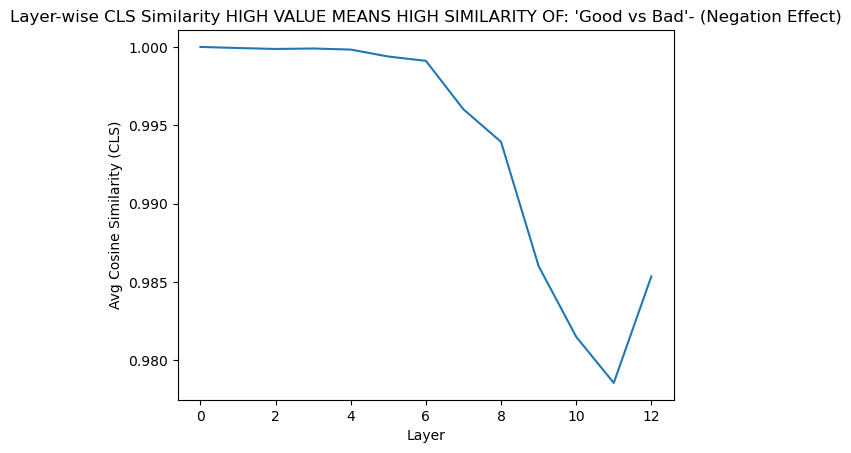

In [86]:
'''THIS SEGMENT COMPARES AND VISUALIZES HOW EACHLAYER DIFFERENCIATE BETWEEN NEGATED AND NON-NEGATED SENTENCES'''
from torch.nn.functional import cosine_similarity

similarities = [
    cosine_similarity(g, b, dim=-1).mean().item()
    for g, b in zip(cls_good, cls_bad)
]

# Plot similarity by layer
import matplotlib.pyplot as plt
plt.plot(similarities)
plt.xlabel("Layer")
plt.ylabel("Avg Cosine Similarity (CLS)")
plt.title("Layer-wise CLS Similarity HIGH VALUE MEANS HIGH SIMILARITY OF: 'Good vs Bad'- (Negation Effect)")
plt.show()


    Layer  Cosine Similarity
0       0           1.000000
1       1           0.999930
2       2           0.999871
3       3           0.999900
4       4           0.999831
5       5           0.999387
6       6           0.999111
7       7           0.996016
8       8           0.993940
9       9           0.986012
10     10           0.981500
11     11           0.978553
12     12           0.985349


/var/folders/y_/sg8d8nw50zs7026sld3dtkr80000gn/T/ipykernel_1602/1785100567.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Layer', y='Cosine Similarity', data=df, palette='viridis')


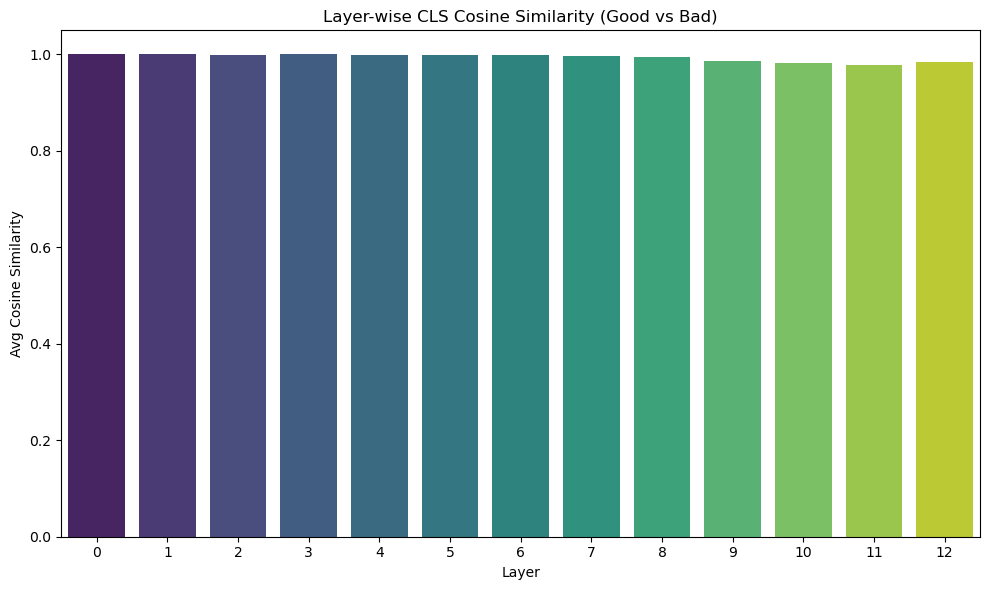

In [88]:
'''THIS SEGMENT VISUALIZES THE REP. SIMILARITY'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrame
df = pd.DataFrame({
    'Layer': list(range(len(similarities))),
    'Cosine Similarity': similarities
})

# Display table
print(df)

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Layer', y='Cosine Similarity', data=df, palette='viridis')
plt.title('Layer-wise CLS Cosine Similarity (Good vs Bad)')
plt.xlabel('Layer')
plt.ylabel('Avg Cosine Similarity')
plt.tight_layout()
plt.show()


In [89]:
'''THIS SEGMENT IMPORT LIBRARIES FOR ML ALGORITHMS'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [90]:
'''THIS SEGMENT ALIGN LABEL ACCORDINGLY'''
# where 1 = good, 0 = bad
labels = [1]*len(cls_good[0]) + [0]*len(cls_bad[0])

# function to stack good + bad from a given layer
def get_layer_features(layer_index):
    X = torch.cat([cls_good[layer_index], cls_bad[layer_index]], dim=0)
    return X.numpy()


In [91]:
'''THIS SEGMENT TRAINS CLASSIFIERS ON CLS TOKEN FROM EACH LAYERS'''
results = []

for i in range(len(cls_good)):  # loop over layers
    X = get_layer_features(i)
    y = labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'SVM': SVC(),
        'Random Forest': RandomForestClassifier()
    }

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append({'Layer': i, 'Classifier': name, 'Accuracy': acc})

        
        # Save classifier per layer and model type

        filename = f"classifiers/classifiers_layer_{i}.pkl"
        joblib.dump(clf, filename)

print("✅ All models saved per layer.")


✅ All models saved per layer.


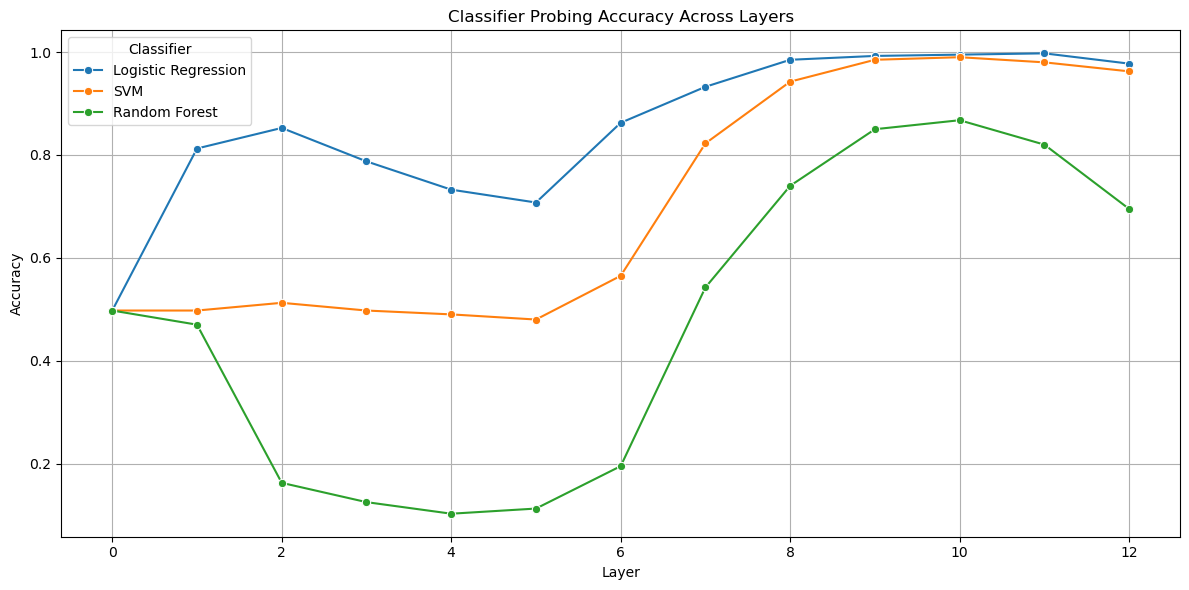

Classifier  Logistic Regression  Random Forest    SVM
Layer                                                
0                         0.498          0.498  0.498
1                         0.812          0.470  0.498
2                         0.852          0.162  0.512
3                         0.788          0.125  0.498
4                         0.732          0.102  0.490
5                         0.708          0.112  0.480
6                         0.862          0.195  0.565
7                         0.932          0.542  0.822
8                         0.985          0.740  0.942
9                         0.992          0.850  0.985
10                        0.995          0.868  0.990
11                        0.998          0.820  0.980
12                        0.978          0.695  0.962


In [93]:
'''THIS SEGMENT VISUALIZES CLASSIFIER RESULTS'''
# Convert to DataFrame
results_df = pd.DataFrame(results)

# Plot: Accuracy per Classifier Across Layers
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='Layer', y='Accuracy', hue='Classifier', marker='o')
plt.title("Classifier Probing Accuracy Across Layers")
plt.ylabel("Accuracy")
plt.xlabel("Layer")
plt.grid(True)
plt.tight_layout()
plt.show()

# Display as Table
print(results_df.pivot(index='Layer', columns='Classifier', values='Accuracy').round(3))
